# タイトル
## 精神的健康状態の識別
目的変数をtreatment（精神的健康状態の治療を受けたことがあるか）とします。

# 氏名
## 橋本淳一

# 課題
## Mental Health in Tech Survey


# 目次
1. 使用データの説明
1. CSVを読み込み不要な列を除外する
1. 欠測値の補完
1. 前処理（一部）
1. 目的変数と説明変数の関係を確認するためにグラフ化し、異常値の確認
1. 目的変数を説明するのに有効そうな説明変数
1. 前処理
    1. データの数値化
1. データの準備
    1. トレインとテストの分割
    1. ターゲットエンコーディング
1. 決定木
1. ランダムフォレスト
1. アダブースト
1. 説明変数の重要度を出力する
1. 説明変数の重要度からわかること


# 使用データの説明
データは、以下のカラムを持ちます。

* Timestamp
    * 回答日時
* Age
    * 年齢
* Gender
    * 性別
* Country
    * 国籍
* state
    * 米国に住んでいる場合、どの州または地域に住んでいるか
* self_employed
    * 自営業ですか？
* family_history
    * 精神病の家族歴はありますか？
* treatment
    * 精神的健康状態の治療を受けたことがありますか？
* work_interfere
    * あなたの心的健康状態が、あたの仕事を妨害すると感じますか？
* no_employees
    * あなたの会社や組織には何人の従業員がいますか？
* remote_work
    * 勤務時間の少なくともも50％はリモートで（オフィスの外で）働いていますか？
* tech_company
    * あなたの雇用主は主に技術系の企業/組織ですか？
* benefits
    * あなたの雇用主は精神保健給付を提供していますか？
* care_options
    * 雇用主が提供する精神保健医療の選択肢を知っていますか？
* wellness_program
    * あなたの雇用主は従業員の健康プログラムの一環としてメンタルヘルスについて議論しましたか？
* seek_help
    * あなたの雇用主は、メンタルヘルスの問題や助けを求める方法についての詳細を学ぶためのリソースを提供していますか？
* anonymity
    * メンタルヘルスや薬物乱用の治療リソースを利用することを選択した場合、匿名性は保護されていますか？
* leave
    * あなたが精神的健康状態のために休暇をとることは容易ですか？
* mental_health_consequence
    * あなたの雇用主との精神の健康問題について話し合うことは悪影響を及ぼすと思いますか？
* phys_health_consequence
    * あなたの雇用主との身体の健康上の問題について話し合うことは悪影響を及ぼすと思いますか？
* coworkers
    * あなたの同僚と精神衛生上の問題について話し合いたいですか？
* supervisor
    * あなたはあなたの直属の上司と精神衛生上の問題について話し合いたいですか？
* mental_health_interview
    * インタビューで潜在的な雇用主との精神衛生問題を提起しますか？
* phys_health_interview
    * インタビューで潜在的な雇用主との身体的健康問題を提起しますか？
* mental_vs_physical
    * あなたの雇用主は精神的健康を肉体的健康と同じくらい重視していると感じますか？
* obs_consequence
    * あなたの職場で精神的健康状態のよくない同僚について否定的な結果を聞いたり、見たりしましたか？
* comments
    * 追加のメモまたはコメント


# CSVを読み込み不要な列を除外する

In [222]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


## CSVを読み込む

In [223]:
df_data = pd.read_csv('../1_data/survey.csv')
print(df_data.columns)

df_data.head()

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


## 不要な列を除外する
* Timestamp（情報が提出された日時）が目的変数に影響がなさそうなので、除外する
* comments（追加のメモ）は説明変数としては使えないので、除外する

In [224]:
df_data_exclude_unnecessary = df_data.drop(["Timestamp", "comments"], axis=1)
df_data_exclude_unnecessary.head()

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


# 欠測値の補完
## 欠測値を数える

In [225]:
pd.DataFrame(df_data_exclude_unnecessary.isnull().sum(), columns=["num of NaN"])

,num of NaN
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0
remote_work,0


## 補完
欠測値を'missing'で補完する

In [226]:
df_data_new = df_data_exclude_unnecessary.fillna('missing')

NaNを補完したことを確認する

In [227]:
pd.DataFrame(df_data_new.isnull().sum(), columns=["num of NaN"])

,num of NaN
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0
remote_work,0


# 前処理（一部）
可視化の都合で、一部前処理をします。
* Genderの不正な値を除外します。
* Treatmentは数値化します。 

## Genderの名寄せ

In [228]:
col = "Gender"
df_data_new[col].replace("All","all", inplace=True)
df_gender = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df_gender.T.sort_values("All",ascending=False))

treatment,No,Yes,All
Gender,,,
All,622,637,1259
Male,330,285,615
male,112,94,206
Female,37,84,121
M,69,47,116
female,16,46,62
F,12,26,38
m,20,14,34
f,6,9,15


In [229]:
df_data_new["Gender_numeric"] = df_data_new["Gender"].map({"Male":1,"Female":0,"male":1,"female":0,"M":1,"F":0})
df_data_new["Gender_numeric"]


0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       0.0
7       1.0
8       0.0
9       1.0
10      1.0
11      1.0
12      0.0
13      1.0
14      1.0
15      0.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      0.0
28      1.0
29      1.0
       ... 
1229    1.0
1230    0.0
1231    NaN
1232    1.0
1233    1.0
1234    NaN
1235    1.0
1236    1.0
1237    1.0
1238    1.0
1239    1.0
1240    1.0
1241    1.0
1242    1.0
1243    NaN
1244    0.0
1245    1.0
1246    1.0
1247    1.0
1248    0.0
1249    1.0
1250    1.0
1251    1.0
1252    1.0
1253    1.0
1254    1.0
1255    1.0
1256    1.0
1257    NaN
1258    1.0
Name: Gender_numeric, Length: 1259, dtype: float64

## GenderのNaNを-1で置き換える

In [230]:
df_data_new["Gender_numeric"].fillna(-1, inplace=True)
df_data_new["Gender_numeric"]


0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       0.0
7       1.0
8       0.0
9       1.0
10      1.0
11      1.0
12      0.0
13      1.0
14      1.0
15      0.0
16      1.0
17      1.0
18      1.0
19      1.0
20      1.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      0.0
28      1.0
29      1.0
       ... 
1229    1.0
1230    0.0
1231   -1.0
1232    1.0
1233    1.0
1234   -1.0
1235    1.0
1236    1.0
1237    1.0
1238    1.0
1239    1.0
1240    1.0
1241    1.0
1242    1.0
1243   -1.0
1244    0.0
1245    1.0
1246    1.0
1247    1.0
1248    0.0
1249    1.0
1250    1.0
1251    1.0
1252    1.0
1253    1.0
1254    1.0
1255    1.0
1256    1.0
1257   -1.0
1258    1.0
Name: Gender_numeric, Length: 1259, dtype: float64

## 目的変数Treatmentを数値に変換する
* Treatmentが'Yes','No'なので、数値に変換したカラム（treatment_numeric）をDataFrameに追加します。
* 'Yes'を1、'No'を0とします。

In [231]:
treatment_mapping = { 'No' : 0, 'Yes' : 1 }

df_data_new['treatment_numeric'] = df_data_new['treatment'].map(treatment_mapping)
df_data_new.head()

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Gender_numeric,treatment_numeric
0,37,Female,United States,IL,missing,No,Yes,Often,6-25,No,...,No,No,Some of them,Yes,No,Maybe,Yes,No,0.0,1
1,44,M,United States,IN,missing,No,No,Rarely,More than 1000,No,...,Maybe,No,No,No,No,No,Don't know,No,1.0,0
2,32,Male,Canada,missing,missing,No,No,Rarely,6-25,No,...,No,No,Yes,Yes,Yes,Yes,No,No,1.0,0
3,31,Male,United Kingdom,missing,missing,Yes,Yes,Often,26-100,No,...,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,1.0,1
4,31,Male,United States,TX,missing,No,No,Never,100-500,Yes,...,No,No,Some of them,Yes,Yes,Yes,Don't know,No,1.0,0


# 目的変数と説明変数の関係を確認するためにグラフ化し、異常値の確認
## Ageの異常値を確認

In [232]:
df_data_new.Age.sort_values()

715           -1726
143             -29
1127             -1
734               5
989               8
1090             11
282              18
287              18
43               18
482              18
478              18
93               18
118              18
991              19
1027             19
129              19
75               19
150              19
1020             19
749              19
682              19
592              19
1126             20
826              20
437              20
660              20
994              20
1174             20
684              21
425              21
           ...     
574              50
581              50
527              51
856              51
904              51
1159             51
895              51
911              53
347              54
652              54
498              54
372              55
964              55
419              55
1186             56
294              56
870              56
631              56
475              57


## Ageが10~100までのデータを有効とする

In [233]:
df_data_new = df_data_new[(10 <= df_data.Age) & (df_data.Age <= 100)]
df_data_new.Age.sort_values()

1090    11
118     18
482     18
478     18
93      18
43      18
287     18
282     18
991     19
1020    19
592     19
1027    19
75      19
749     19
129     19
682     19
150     19
826     20
1126    20
660     20
994     20
1174    20
437     20
116     21
206     21
374     21
246     21
368     21
1139    21
852     21
        ..
606     50
898     50
581     50
38      50
1159    51
527     51
904     51
895     51
856     51
911     53
347     54
498     54
652     54
419     55
964     55
372     55
1186    56
631     56
870     56
294     56
475     57
643     57
466     57
471     58
1236    60
297     60
952     61
520     62
560     65
1182    72
Name: Age, Length: 1252, dtype: int64

## Ageとtreatmentの関係を可視化

,treatment_numeric,Age
0,1,37
1,0,44
2,0,32
3,1,31
4,0,31


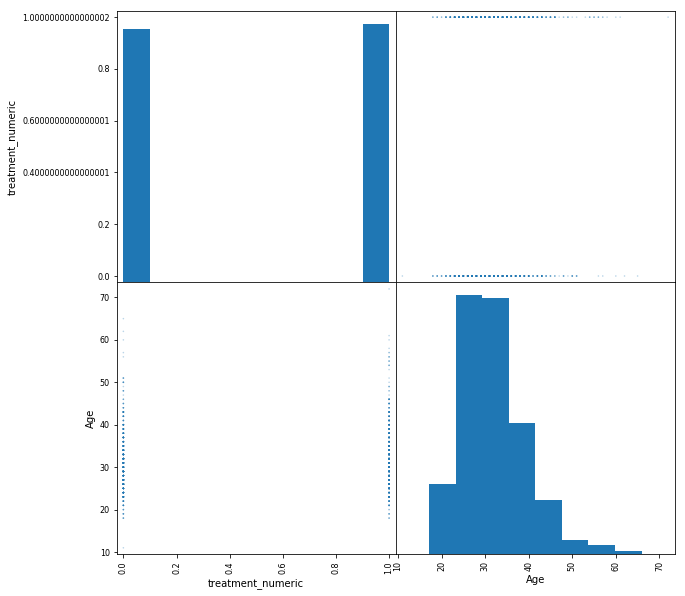

In [234]:
y_var = "treatment_numeric"
X_var = ["Age"]
df = df_data_new[[y_var] + X_var]
display(df.head())

pd.plotting.scatter_matrix(df,alpha=0.3,s=10, figsize=(10,10))
plt.show()

treatmentの0,1に均等にプロットされているように見えるので、Ageは目的変数への影響は少ない。

## Genderとtreatmentの関係を可視化

In [235]:
col = "Gender_numeric"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))


treatment,No,Yes,All
Gender_numeric,,,
All,620,632,1252
1.0,509,424,933
0.0,65,156,221
-1.0,46,52,98


女性の方が精神疾患に罹る割合が高い。

## Countryとtreatmentの関係を可視化

In [236]:
col = "Country"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
Country,,,
All,620,632,1252
United States,339,408,747
United Kingdom,92,92,184
Canada,35,37,72
Germany,24,21,45
Netherlands,18,9,27
Ireland,14,13,27
Australia,8,13,21
France,11,2,13


国籍によって、精神疾患に罹る割合が異なる。

## Countryのヒストグラム

(array([ 37.,  79.,   9.,  61.,  50.,   6.,  38.,  13.,  19., 940.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <a list of 10 Patch objects>)

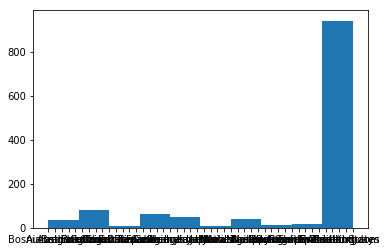

In [237]:
plt.hist(df_data_new["Country"])


## Stateとtreatmentの関係を可視化

In [238]:
col = "state"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
state,,,
All,620,632,1252
missing,285,228,513
CA,52,86,138
WA,29,41,70
NY,27,30,57
TN,27,18,45
TX,19,25,44
OR,12,17,29
PA,15,14,29


州によって、精神疾患に罹る割合が異なる。

## self_employedとtreatmentの関係を可視化

In [239]:
col = "self_employed"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
self_employed,,,
All,620,632,1252
No,543,548,1091
Yes,68,75,143
missing,9,9,18


自営業かどうかは、精神疾患にかかる割合への影響は少ない。

## family_historyとtreatmentの関係を可視化

In [240]:
col = "family_history"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
family_history,,,
All,620,632,1252
No,493,270,763
Yes,127,362,489


家族歴がある人の方が、精神疾患に罹る割合が高い。

## work_interfereとtreatmentの関係を可視化

In [241]:
col = "work_interfere"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
work_interfere,,,
All,620,632,1252
Sometimes,107,357,464
missing,258,4,262
Never,183,30,213
Rarely,51,122,173
Often,21,119,140


あなたの精神的健康状態が、あたの仕事を妨害すると感じる人の方が、精神疾患に罹る割合が高い。

## no_employeesとtreatmentの関係を可視化

In [242]:
col = "no_employees"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
no_employees,,,
All,620,632,1252
6-25,162,127,289
26-100,139,149,288
More than 1000,135,146,281
100-500,80,95,175
1-5,71,88,159
500-1000,33,27,60


従業員の数は、精神疾患に罹る割合にあまり影響しない。

## remote_workとtreatmentの関係を可視化

In [243]:
col = "remote_work"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
remote_work,,,
All,620,632,1252
No,443,437,880
Yes,177,195,372


リモートワークの有無は、精神疾患に罹る割合にあまり影響しない。

## tech_companyとtreatmentの関係を可視化

In [244]:
col = "tech_company"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
tech_company,,,
All,620,632,1252
Yes,516,510,1026
No,104,122,226


技術系企業かどうかは、精神疾患に罹る割合にあまり影響しない。

## benefitsとtreatmentの関係を可視化

In [245]:
col = "benefits"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
benefits,,,
All,620,632,1252
Yes,171,302,473
Don't know,256,151,407
No,193,179,372


雇用主が精神保健給付を提供している方が、精神疾患に罹る割合が高い。

## care_optionsとtreatmentの関係を可視化

In [246]:
col = "care_options"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
care_options,,,
All,620,632,1252
No,293,206,499
Yes,137,303,440
Not sure,190,123,313


雇用主が提供する精神保健医療の選択肢を知っている人の方が、精神疾患に罹る割合が高い。

## wellness_programとtreatmentの関係を可視化

In [247]:
col = "wellness_program"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
wellness_program,,,
All,620,632,1252
No,421,417,838
Yes,93,134,227
Don't know,106,81,187


雇用主がメンタルヘルスについて議論した人の方が、精神疾患に罹る割合が高い。

## seek_helpとtreatmentの関係を可視化

In [248]:
col = "seek_help"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
seek_help,,,
All,620,632,1252
No,322,320,642
Don't know,197,166,363
Yes,101,146,247


雇用主がメンタルヘルスの問題や助けを求める方法についての詳細を学ぶためのリソースを提供している人の方が、精神疾患に罹る割合が高い。

## anonymityとtreatmentの関係を可視化

In [249]:
col = "anonymity"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
anonymity,,,
All,620,632,1252
Don't know,446,369,815
Yes,147,226,373
No,27,37,64


匿名性が保護されているかどうかは、精神疾患に罹る割合にあまり影響しない。

## leaveとtreatmentの関係を可視化

In [250]:
col = "leave"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
leave,,,
All,620,632,1252
Don't know,308,253,561
Somewhat easy,134,131,265
Very easy,103,101,204
Somewhat difficult,44,81,125
Very difficult,31,66,97


精神的健康状態のために休暇をとることが難しい人の方が、精神疾患に罹る割合が高い。

## mental_health_consequenceとtreatmentの関係を可視化

In [251]:
col = "mental_health_consequence"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
mental_health_consequence,,,
All,620,632,1252
No,278,210,488
Maybe,224,252,476
Yes,118,170,288


雇用主との精神の健康問題について話し合うことは悪影響を及ぼすと思う人の方が、精神疾患に罹る割合が高い。

## phys_health_consequenceとtreatmentの関係を可視化

In [252]:
col = "phys_health_consequence"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
phys_health_consequence,,,
All,620,632,1252
No,468,453,921
Maybe,127,146,273
Yes,25,33,58


雇用主との身体の健康上の問題について話し合うことは悪影響を及ぼす人の方が、精神疾患に罹る割合が高い。

## coworkersとtreatmentの関係を可視化

In [253]:
col = "coworkers"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
coworkers,,,
All,620,632,1252
Some of them,383,389,772
No,141,117,258
Yes,96,126,222


同僚と精神衛生上の問題について話し合いたい人の方が、精神疾患に罹る割合が高い。

## supervisorとtreatmentの関係を可視化

In [254]:
col = "supervisor"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
supervisor,,,
All,620,632,1252
Yes,264,248,512
No,186,204,390
Some of them,170,180,350


直属の上司と精神衛生上の問題について話し合いたくない人の方が、精神疾患に罹る割合が高い。

## mental_health_interviewとtreatmentの関係を可視化

In [255]:
col = "mental_health_interview"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
mental_health_interview,,,
All,620,632,1252
No,477,527,1004
Maybe,125,82,207
Yes,18,23,41


インタビューで潜在的な雇用主との精神衛生問題を提起するかどうかは、精神疾患に罹る割合にあまり影響しない。

## phys_health_interviewとtreatmentの関係を可視化

In [256]:
col = "phys_health_interview"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
phys_health_interview,,,
All,620,632,1252
Maybe,290,266,556
No,239,257,496
Yes,91,109,200


インタビューで潜在的な雇用主との身体的健康問題を提起するかどうかは、精神疾患に罹る割合にあまり影響しない。

## mental_vs_physicalとtreatmentの関係を可視化

In [257]:
col = "mental_vs_physical"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
mental_vs_physical,,,
All,620,632,1252
Don't know,315,259,574
Yes,167,173,340
No,138,200,338


雇用主が精神的健康を肉体的健康と同じくらい重視していると感じない人の方が、精神疾患に罹る割合が高い。

## obs_consequenceとtreatmentの関係を可視化

In [258]:
col = "obs_consequence"
df = pd.crosstab(index=df_data_new["treatment"], columns=df_data_new[col], margins=True)
display(df.T.sort_values("All",ascending=False))

treatment,No,Yes,All
obs_consequence,,,
All,620,632,1252
No,564,507,1071
Yes,56,125,181


職場で精神的健康状態のよくない同僚について否定的な結果を聞いたり、見たりした人の方が、精神疾患に罹る割合が高い。

# 目的変数を説明するのに有効そうな説明変数
可視化した結果から、以下の説明変数は、TreartmentのYes/Noの割合に差があり、目的変数への影響が高そうです。
* Gender
* Country
* State
* family_history
* work_interfere
* benefits
* care_options
* wellness_program
* seek_help
* leave
* mental_health_consequence
* phys_health_consequence
* coworkers
* supervisor
* mental_vs_physical
* obs_consequence

# 前処理

## self_employedの数値化

In [259]:
mapping = { "No" : 0, "Yes" : 1, "missing" : -1 }

df_data_new["self_employed_numeric"] = df_data_new["self_employed"].map(mapping)
df_data_new["self_employed_numeric"]

0      -1
1      -1
2      -1
3      -1
4      -1
5      -1
6      -1
7      -1
8      -1
9      -1
10     -1
11     -1
12     -1
13     -1
14     -1
15     -1
16     -1
17     -1
18      1
19      1
20      0
21      1
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1229    0
1230    0
1231    1
1232    0
1233    0
1234    0
1235    0
1236    0
1237    0
1238    0
1239    0
1240    0
1241    1
1242    0
1243    0
1244    0
1245    0
1246    0
1247    0
1248    0
1249    0
1250    1
1251    0
1252    0
1253    0
1254    0
1255    0
1256    0
1257    0
1258    0
Name: self_employed_numeric, Length: 1252, dtype: int64

## family_historyの数値化

In [260]:
mapping = { "No" : 0, "Yes" : 1, "missing" : -1 }

df_data_new["family_history_numeric"] = df_data_new["family_history"].map(mapping)
df_data_new["family_history_numeric"]

0       0
1       0
2       0
3       1
4       0
5       1
6       1
7       0
8       1
9       0
10      0
11      0
12      1
13      1
14      0
15      1
16      0
17      0
18      1
19      1
20      1
21      0
22      0
23      0
24      1
25      1
26      0
27      1
28      0
29      0
       ..
1229    0
1230    1
1231    0
1232    1
1233    0
1234    0
1235    0
1236    0
1237    0
1238    1
1239    0
1240    1
1241    0
1242    0
1243    1
1244    0
1245    1
1246    0
1247    0
1248    1
1249    1
1250    1
1251    1
1252    1
1253    1
1254    0
1255    1
1256    1
1257    0
1258    1
Name: family_history_numeric, Length: 1252, dtype: int64

## work_interfereの数値化


In [261]:
mapping = { "Never" : 0, "Rarely" : 1, "Often" : 2, "Sometimes" : 3, "missing" : -1 }

df_data_new["work_interfere_numeric"] = df_data_new["work_interfere"].map(mapping)
df_data_new["work_interfere_numeric"]

0       2
1       1
2       1
3       2
4       0
5       3
6       3
7       0
8       3
9       0
10      3
11      0
12      3
13      0
14      0
15      1
16      3
17      3
18      3
19     -1
20      3
21      0
22      2
23      0
24      1
25      3
26     -1
27      1
28      3
29      3
       ..
1229   -1
1230    3
1231    3
1232    3
1233    1
1234    3
1235    2
1236    2
1237    3
1238    2
1239    3
1240    3
1241    2
1242    1
1243    1
1244   -1
1245    2
1246    0
1247    2
1248    3
1249    3
1250    2
1251    2
1252    3
1253    1
1254   -1
1255    2
1256    3
1257   -1
1258    3
Name: work_interfere_numeric, Length: 1252, dtype: int64

## no_employeesの数値化

In [262]:
mapping = { "1-5" : 1, "6-25" : 2, "26-100" : 3, "100-500" : 4, "500-1000" : 5, "More than 1000" : 6, "missing" : -1 }

df_data_new["no_employees_numeric"] = df_data_new["no_employees"].map(mapping)
df_data_new["no_employees_numeric"]

0       2
1       6
2       2
3       3
4       4
5       2
6       1
7       1
8       4
9       3
10      2
11      4
12      3
13      5
14      2
15      3
16      3
17      2
18      1
19      2
20      4
21      1
22      3
23      6
24      3
25      6
26      1
27      2
28      3
29      2
       ..
1229    2
1230    2
1231    2
1232    6
1233    2
1234    2
1235    3
1236    6
1237    3
1238    6
1239    5
1240    4
1241    2
1242    3
1243    6
1244    6
1245    4
1246    4
1247    2
1248    3
1249    3
1250    3
1251    4
1252    4
1253    6
1254    3
1255    3
1256    6
1257    4
1258    3
Name: no_employees_numeric, Length: 1252, dtype: int64

## remote_workの数値化

In [263]:
mapping = { "No" : 0, "Yes" : 1, "missing" : -1 }

df_data_new["remote_work_numeric"] = df_data_new["remote_work"].map(mapping)
df_data_new["remote_work_numeric"]

0       0
1       0
2       0
3       0
4       1
5       0
6       1
7       1
8       0
9       0
10      1
11      1
12      0
13      0
14      0
15      0
16      1
17      0
18      1
19      1
20      0
21      1
22      1
23      0
24      0
25      0
26      0
27      1
28      1
29      0
       ..
1229    1
1230    0
1231    1
1232    0
1233    0
1234    0
1235    0
1236    1
1237    0
1238    0
1239    0
1240    0
1241    1
1242    0
1243    1
1244    0
1245    0
1246    0
1247    0
1248    0
1249    0
1250    0
1251    0
1252    1
1253    0
1254    0
1255    1
1256    0
1257    1
1258    0
Name: remote_work_numeric, Length: 1252, dtype: int64

## tech_companyの数値化

In [264]:
mapping = { "No" : 0, "Yes" : 1, "missing" : -1 }

df_data_new["tech_company_numeric"] = df_data_new["tech_company"].map(mapping)
df_data_new["tech_company_numeric"]

0       1
1       0
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      0
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      0
24      1
25      0
26      1
27      1
28      1
29      1
       ..
1229    1
1230    1
1231    1
1232    0
1233    1
1234    0
1235    1
1236    1
1237    1
1238    0
1239    1
1240    1
1241    1
1242    1
1243    1
1244    0
1245    0
1246    1
1247    1
1248    1
1249    1
1250    1
1251    0
1252    1
1253    0
1254    1
1255    1
1256    1
1257    1
1258    0
Name: tech_company_numeric, Length: 1252, dtype: int64

## leaveの数値化

In [265]:
mapping = { "missing" : -1, "Don't know" : -1,"Very easy" : 1, "Somewhat easy" : 2, "Somewhat difficult" : 3, "Very difficult" : 4 }

df_data_new["leave_numeric"] = df_data_new["leave"].map(mapping)
df_data_new["leave_numeric"]

0       2
1      -1
2       3
3       3
4      -1
5      -1
6       3
7      -1
8       4
9      -1
10     -1
11     -1
12      3
13     -1
14      2
15      2
16      1
17     -1
18      1
19      2
20      3
21      3
22     -1
23     -1
24     -1
25      1
26     -1
27     -1
28      3
29      4
       ..
1229   -1
1230    1
1231   -1
1232    1
1233   -1
1234   -1
1235   -1
1236    2
1237   -1
1238    2
1239   -1
1240    2
1241    2
1242   -1
1243   -1
1244   -1
1245   -1
1246    2
1247    4
1248   -1
1249    1
1250   -1
1251    2
1252   -1
1253    2
1254    2
1255    3
1256    3
1257   -1
1258   -1
Name: leave_numeric, Length: 1252, dtype: int64

## mental_health_consequenceの数値化

In [266]:
mapping = { "No" : 1, "Maybe" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["mental_health_consequence_numeric"] = df_data_new["mental_health_consequence"].map(mapping)
df_data_new["mental_health_consequence_numeric"]

0       1
1       2
2       1
3       3
4       1
5       1
6       2
7       1
8       2
9       1
10      1
11      1
12      3
13      1
14      1
15      1
16      2
17      2
18      1
19      1
20      2
21      1
22      2
23      2
24      1
25      3
26      2
27      1
28      1
29      3
       ..
1229    3
1230    1
1231    2
1232    1
1233    1
1234    3
1235    2
1236    2
1237    3
1238    3
1239    2
1240    1
1241    2
1242    2
1243    1
1244    2
1245    2
1246    1
1247    3
1248    3
1249    1
1250    1
1251    1
1252    3
1253    2
1254    1
1255    1
1256    3
1257    3
1258    2
Name: mental_health_consequence_numeric, Length: 1252, dtype: int64

## phys_health_consequenceの数値化

In [267]:
mapping = { "No" : 1, "Maybe" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["phys_health_consequence_numeric"] = df_data_new["phys_health_consequence"].map(mapping)
df_data_new["phys_health_consequence_numeric"]

0       1
1       1
2       1
3       3
4       1
5       1
6       2
7       1
8       1
9       1
10      1
11      1
12      3
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      2
27      1
28      1
29      2
       ..
1229    1
1230    1
1231    2
1232    1
1233    1
1234    2
1235    1
1236    2
1237    2
1238    2
1239    1
1240    1
1241    1
1242    1
1243    1
1244    1
1245    2
1246    1
1247    1
1248    2
1249    1
1250    1
1251    1
1252    1
1253    2
1254    1
1255    1
1256    3
1257    1
1258    1
Name: phys_health_consequence_numeric, Length: 1252, dtype: int64

## coworkersの数値化

In [268]:
mapping = { "No" : 1, "Some of them" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["coworkers_numeric"] = df_data_new["coworkers"].map(mapping)
df_data_new["coworkers_numeric"]

0       2
1       1
2       3
3       2
4       2
5       3
6       2
7       1
8       3
9       3
10      2
11      3
12      3
13      3
14      2
15      3
16      2
17      2
18      3
19      2
20      2
21      2
22      2
23      1
24      3
25      2
26      2
27      3
28      2
29      2
       ..
1229    1
1230    3
1231    2
1232    3
1233    3
1234    1
1235    3
1236    2
1237    1
1238    2
1239    3
1240    2
1241    2
1242    1
1243    2
1244    2
1245    1
1246    1
1247    2
1248    1
1249    3
1250    2
1251    2
1252    2
1253    2
1254    2
1255    2
1256    1
1257    1
1258    2
Name: coworkers_numeric, Length: 1252, dtype: int64

## supervisorの数値化

In [269]:
mapping = { "No" : 1, "Some of them" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["supervisor_numeric"] = df_data_new["supervisor"].map(mapping)
df_data_new["supervisor_numeric"]

0       3
1       1
2       3
3       1
4       3
5       3
6       1
7       1
8       3
9       3
10      3
11      3
12      3
13      3
14      2
15      2
16      1
17      3
18      3
19      2
20      2
21      2
22      3
23      1
24      3
25      3
26      1
27      3
28      1
29      1
       ..
1229    1
1230    3
1231    2
1232    3
1233    3
1234    1
1235    2
1236    1
1237    1
1238    3
1239    3
1240    1
1241    1
1242    1
1243    3
1244    3
1245    3
1246    2
1247    1
1248    1
1249    3
1250    3
1251    3
1252    1
1253    2
1254    2
1255    3
1256    1
1257    1
1258    1
Name: supervisor_numeric, Length: 1252, dtype: int64

## mental_health_interviewの数値化

In [270]:
mapping = { "No" : 1, "Maybe" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["mental_health_interview_numeric"] = df_data_new["mental_health_interview"].map(mapping)
df_data_new["mental_health_interview_numeric"]

0       1
1       1
2       3
3       2
4       3
5       1
6       1
7       1
8       1
9       2
10      1
11      3
12      2
13      1
14      2
15      2
16      2
17      1
18      1
19      2
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      2
28      1
29      1
       ..
1229    1
1230    2
1231    1
1232    3
1233    1
1234    1
1235    1
1236    1
1237    1
1238    1
1239    2
1240    1
1241    1
1242    1
1243    1
1244    1
1245    1
1246    2
1247    1
1248    1
1249    2
1250    2
1251    1
1252    1
1253    1
1254    1
1255    1
1256    1
1257    1
1258    1
Name: mental_health_interview_numeric, Length: 1252, dtype: int64

## phys_health_interviewの数値化

In [271]:
mapping = { "No" : 1, "Maybe" : 2, "Yes" : 3, "missing" : -1 }

df_data_new["phys_health_interview_numeric"] = df_data_new["phys_health_interview"].map(mapping)
df_data_new["phys_health_interview_numeric"]

0       2
1       1
2       3
3       2
4       3
5       2
6       1
7       1
8       2
9       2
10      1
11      3
12      2
13      1
14      3
15      2
16      2
17      1
18      3
19      2
20      1
21      2
22      2
23      3
24      3
25      3
26      1
27      2
28      1
29      2
       ..
1229    1
1230    2
1231    2
1232    3
1233    2
1234    2
1235    1
1236    2
1237    1
1238    1
1239    3
1240    1
1241    1
1242    2
1243    1
1244    3
1245    2
1246    3
1247    2
1248    1
1249    2
1250    2
1251    3
1252    2
1253    1
1254    1
1255    1
1256    1
1257    1
1258    1
Name: phys_health_interview_numeric, Length: 1252, dtype: int64

## obs_consequenceの数値化

In [272]:
mapping = { "No" : 0, "Yes" : 1, "missing" : -1 }

df_data_new["obs_consequence_numeric"] = df_data_new["obs_consequence"].map(mapping)
df_data_new["obs_consequence_numeric"]

0       0
1       0
2       0
3       1
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      1
13      0
14      0
15      0
16      0
17      0
18      1
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1229    0
1230    0
1231    1
1232    0
1233    0
1234    0
1235    0
1236    0
1237    1
1238    1
1239    0
1240    0
1241    0
1242    0
1243    0
1244    0
1245    1
1246    0
1247    1
1248    0
1249    0
1250    0
1251    0
1252    0
1253    0
1254    0
1255    0
1256    0
1257    0
1258    0
Name: obs_consequence_numeric, Length: 1252, dtype: int64

# データの準備
* トレインとテストの分割
* ターゲットエンコーディング

In [273]:
train, test = train_test_split(df_data_new, test_size=0.3, random_state=1234)

# trainのターゲットエンコーディング
for c in train.columns:
    if c in ("Country", "state","benefits","care_options","wellness_program","seek_help","anonymity","mental_vs_physical"):
        vals = train[["treatment_numeric",c]].groupby(c).mean()
        d = vals.to_dict()["treatment_numeric"]
        train[c + '_numeric'] = train[c].replace(d)    

print(train.columns)
train.head()

# testのターゲットエンコーディング
for c in test.columns:
    if c in ("Country", "state","benefits","care_options","wellness_program","seek_help","anonymity","mental_vs_physical"):
        vals = test[["treatment_numeric",c]].groupby(c).mean()
        d = vals.to_dict()["treatment_numeric"]
        test[c + '_numeric'] = test[c].replace(d)    

print(test.columns)
test.head()

# 数値化した元の列を削除
train = train.drop(['Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options','wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers','supervisor', 'mental_health_interview', 'phys_health_interview','mental_vs_physical', 'obs_consequence'], axis=1)
print(train.columns)
train.head()

test = test.drop(['Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options','wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers','supervisor', 'mental_health_interview', 'phys_health_interview','mental_vs_physical', 'obs_consequence'], axis=1)
print(test.columns)
test.head()

X_train = train.drop(["treatment_numeric"], axis=1).values
print("X_train=",X_train)
print()

X_test = test.drop(["treatment_numeric"], axis=1).values
print("X_test=",X_test)
print()

y_train = train["treatment_numeric"].values
print("y_train=",y_train)
print()

y_test = test["treatment_numeric"].values
print("y_test=",y_test)



Index(['Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Gender_numeric',
       'treatment_numeric', 'self_employed_numeric', 'family_history_numeric',
       'work_interfere_numeric', 'no_employees_numeric', 'remote_work_numeric',
       'tech_company_numeric', 'leave_numeric',
       'mental_health_consequence_numeric', 'phys_health_consequence_numeric',
       'coworkers_numeric', 'supervisor_numeric',
       'mental_health_interview_numeric', 'phys_health_interview_numeric',
       'obs_consequence_numeric', 'Country_numeric', 'state_numeric',
       'benefits_numeric', 'care_options_nu

## 決定木
### グリッドサーチで最適なパラメータを探索

In [275]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth':[3,5,7],'min_samples_split':[2,3,4,5],'min_samples_leaf':[2,3,4,5,6]}
cv = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [276]:
cv.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}

In [277]:
print(classification_report(y_test,cv.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.93      0.75      0.83       169
          1       0.82      0.96      0.88       207

avg / total       0.87      0.86      0.86       376



In [278]:
print(confusion_matrix(y_test,cv.best_estimator_.predict(X_test)))

[[126  43]
 [  9 198]]


## ランダムフォレスト
### グリッドサーチで最適なパラメータを探索

In [280]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators':[10,20,50,100],'max_depth':[3,5,7,9,11],'min_samples_split':[2,3,4,5],'min_samples_leaf':[2,3,4,5,6,7,8]}
cv = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,cv=5)
cv.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100], 'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [285]:
cv.best_params_

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

In [286]:
print(classification_report(y_test,cv.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.92      0.78      0.84       169
          1       0.84      0.94      0.89       207

avg / total       0.87      0.87      0.87       376



In [287]:
print(confusion_matrix(y_test,cv.best_estimator_.predict(X_test)))

[[131  38]
 [ 12 195]]


## アダブースト
### グリッドサーチで最適なパラメータを探索

In [303]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {'n_estimators':[10,20,50,100],'learning_rate':[1,2,3,4,5]}
cv = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()),param_grid=param_grid,cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100], 'learning_rate': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [304]:
cv.best_params_

{'learning_rate': 2, 'n_estimators': 100}

In [305]:
print(classification_report(y_test,cv.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.75      0.80      0.78       169
          1       0.83      0.78      0.81       207

avg / total       0.80      0.79      0.79       376



In [306]:
print(confusion_matrix(y_test,cv.best_estimator_.predict(X_test)))

[[136  33]
 [ 45 162]]


ランダムフォレストが最も精度が高かった（f1_score:0.87）

## 説明変数の重要度を出力する
ランダムフォレストで説明変数の重要度を出力する。

score= 0.8664383561643836
[0.02133348 0.02419264 0.00316201 0.14480339 0.43373056 0.01128776
 0.00679521 0.0051722  0.03182255 0.01600783 0.00598735 0.00991644
 0.00722544 0.00536459 0.0081571  0.01498823 0.05567915 0.06346837
 0.03948825 0.04922081 0.01062589 0.00963207 0.01372759 0.00821107]


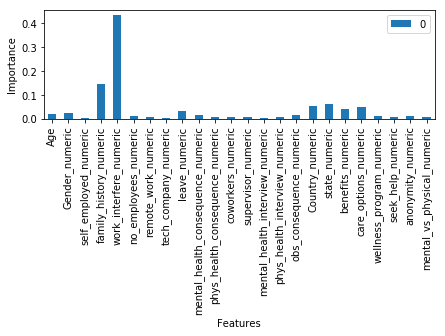

In [311]:
# 最適なパラメータを指定する
clf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion="gini",
                                                 min_samples_leaf=3, min_samples_split=4, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=train.drop(["treatment_numeric"], axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

# 説明変数の重要度からわかること
* work_interfareが最も重要語が高い
    * 精神の状態が仕事に影響すると自分で思い込むと、精神疾患にかかりやすい。
* famly_historyが次に重要度が高い
    * 家族に精神疾患を患った人がいると、自分も精神疾患にかかりやすい。